# Round 7: Improve the accuracy of your model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

df = pd.read_csv("../lab-customer-analysis-round-5/files_for_lab/csv_files/marketing_customer_analysis.csv")
df.columns = [df.columns[col_name].lower().replace(' ','_') for col_name in range(len(df.columns))] # Standarize columns
df = df.set_index('customer')
df.sample(5)

,state,customer_lifetime_value,response,coverage,education,effective_to_date,employmentstatus,gender,income,location_code,...,months_since_policy_inception,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size
customer,,,,,,,,,,,,,,,,,,,,,
PC43437,Arizona,7317.014254,No,Basic,College,1/20/11,Employed,F,24083,Suburban,...,2,1,2,Personal Auto,Personal L3,Offer1,Agent,340.453606,Four-Door Car,Small
WK99918,Oregon,5073.282126,Yes,Extended,Doctor,1/30/11,Employed,M,57709,Suburban,...,26,0,1,Personal Auto,Personal L1,Offer2,Branch,600.000000,SUV,Medsize
QT39597,Arizona,2926.829158,No,Basic,High School or Below,2/4/11,Employed,M,26242,Urban,...,69,0,1,Personal Auto,Personal L3,Offer2,Branch,347.060173,Four-Door Car,Medsize
GF12712,California,9559.340024,No,Extended,High School or Below,1/24/11,Employed,F,40672,Suburban,...,99,0,3,Corporate Auto,Corporate L3,Offer1,Call Center,580.800000,SUV,Medsize
QO79771,California,3242.043926,No,Extended,Master,2/10/11,Employed,F,72330,Rural,...,50,2,1,Personal Auto,Personal L3,Offer2,Call Center,126.509441,Four-Door Car,Small


In [2]:
# X-y split

y = df['total_claim_amount']
X = df.drop(['total_claim_amount'], axis=1)
X.columns

Index(['state', 'customer_lifetime_value', 'response', 'coverage', 'education',
       'effective_to_date', 'employmentstatus', 'gender', 'income',
       'location_code', 'marital_status', 'monthly_premium_auto',
       'months_since_last_claim', 'months_since_policy_inception',
       'number_of_open_complaints', 'number_of_policies', 'policy_type',
       'policy', 'renew_offer_type', 'sales_channel', 'vehicle_class',
       'vehicle_size'],
      dtype='object')

In [3]:
# Separate numerical and categorical values

X_num = X.select_dtypes(include='number')
X_cat = X.select_dtypes(exclude='number')

### EXERCISE: Use the concept of multicollinearity and remove insignificant variables

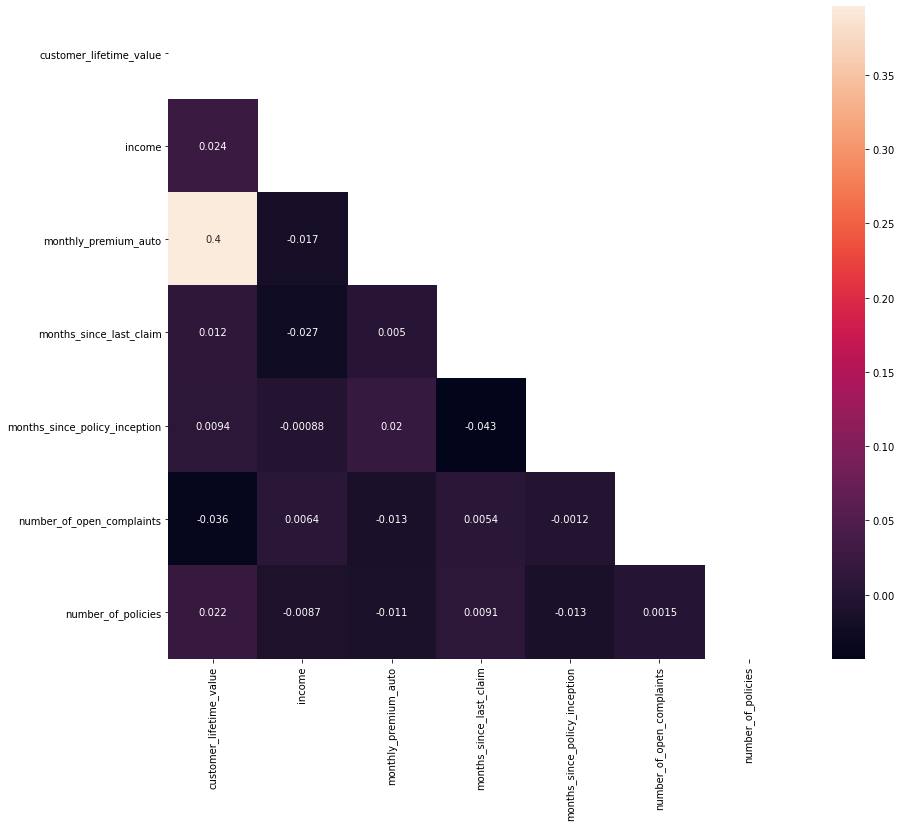

In [4]:
corr_mat = X_num.corr(method='spearman')

mask = np.zeros_like(corr_mat)
mask[np.triu_indices_from(mask)] = True # Mask to hide the repeated half of the matrix

fig, ax = plt.subplots(figsize=(14, 12))
ax = sns.heatmap(X_num.corr(), mask=mask, annot=True)
plt.show() # No values show high correlation. Keep all columns.

### EXERCISE: Use a different method of scaling the numerical variables: Normalizer

In [5]:
# Normalizer: use after the X-y split!

transformer = Normalizer() # initialize Normalizer assigning it to a variable. No need to fit, estimator cannot be changed

In [6]:
# Transform X data with the transformer

X_trans = pd.DataFrame( # convert np array returned by scaler.transform() into a pd dataframe
    data=transformer.transform(X_num), # use scaler to put all numerical values between 0 (X_train min) and 1 (X_train max)
    index=X_num.index, columns=X_num.columns) # set index and column names of the new dataframe
X_trans.sample(5)

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
customer,,,,,,,
NZ57065,0.077741,0.996972,0.001975,0.000271,0.000298,0.0,0.000027
ET87938,0.172551,0.984997,0.002471,0.000598,0.000438,0.0,0.000239
WV37081,0.194879,0.980823,0.002493,0.000416,0.001322,0.0,0.000340
AL21967,0.135734,0.990745,0.001121,0.000454,0.000027,0.0,0.000027
XV76553,0.060259,0.998181,0.001492,0.000200,0.000826,0.0,0.000013


In [7]:
# One Hot Encoding categorical variables

encoder = OneHotEncoder(handle_unknown='error', drop='first') #drop one column for efficiency. It can be deduced
X_cat_encoded = encoder.fit_transform(X_cat).toarray()
X_cat_encoded

array([[0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 1., 0.]])

In [8]:
# Concat normalized numerical dataframe with encoded categorical dataframe

column_names = list(X_trans.columns) # get list of numerical column names
column_names.extend(list(encoder.get_feature_names())) # add list of dummified categorical column names

X_numcat = np.concatenate([X_trans, X_cat_encoded], axis=1)
X_ready = pd.DataFrame(data=X_numcat, index=X.index, columns=column_names)
X_ready.sample(5)

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,x0_California,x0_Nevada,x0_Oregon,...,x12_Branch,x12_Call Center,x12_Web,x13_Luxury Car,x13_Luxury SUV,x13_SUV,x13_Sports Car,x13_Two-Door Car,x14_Medsize,x14_Small
customer,,,,,,,,,,,,,,,,,,,,,
VA95387,0.153302,0.988178,0.001293,0.000424,0.000657,0.000000,0.000042,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
CE94751,0.999855,0.000000,0.015319,0.001094,0.007222,0.000219,0.001532,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
QZ44356,0.999889,0.000000,0.013466,0.001862,0.006017,0.000000,0.001146,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
MO33320,0.250169,0.968196,0.003492,0.000698,0.000054,0.000000,0.000161,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
XH93021,0.999856,0.000000,0.015073,0.002206,0.007353,0.000000,0.001103,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [9]:
# TRAIN-TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(X_ready, y, test_size=0.3, random_state=42)

In [10]:
# Apply linear regression: initialize Linear Regression and fit TRAIN X and TRAIN y data (target)

model = LinearRegression().fit(X_train,y_train)

In [11]:
# EXERCISE: Model validation

prediction = model.predict(X_test) # model predicts TEST y data (target) using TEST X data

R2 = r2_score(y_test, prediction) # correlation between TEST y data and PREDICTED y data
MSE = mean_squared_error(y_test, prediction, squared=True)
RMSE = mean_squared_error(y_test, prediction, squared=False)
MAE = mean_absolute_error(y_test, prediction)

print("R2:", round(R2,2), "|| 0.74 was the previous value using BoxCox Transformation")
print("MSE:", round(MSE,2), "|| 21149.99 was the previous value using BoxCox Transformation")
print("RMSE:", round(RMSE,2), "|| 145.43 was the previous value using BoxCox Transformation")
print("MAE:", round(MAE,2), "|| 98.47 was the previous value using BoxCox Transformation")

R2: 0.74 || 0.74 was the previous value using BoxCox Transformation
MSE: 20970.0 || 21149.99 was the previous value using BoxCox Transformation
RMSE: 144.81 || 145.43 was the previous value using BoxCox Transformation
MAE: 98.56 || 98.47 was the previous value using BoxCox Transformation


### EXERCISE: Use a different method of scaling the numerical variables: MinMaxScaler

In [12]:
# One Hot Encoding categorical variables

encoder = OneHotEncoder(handle_unknown='error', drop='first') #drop one column for efficiency. It can be deduced
X_cat_encoded = encoder.fit_transform(X_cat).toarray()
X_cat_encoded

array([[0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 1., 0.]])

In [13]:
# Concat DataFrames

column_names = list(X_num.columns) # get list of numerical column names
column_names.extend(list(encoder.get_feature_names())) # add list of dummified categorical column names

X_numcat = np.concatenate([X_num, X_cat_encoded], axis=1)
X_ready = pd.DataFrame(data=X_numcat, index=X.index, columns=column_names)
X_ready.sample(5)

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,x0_California,x0_Nevada,x0_Oregon,...,x12_Branch,x12_Call Center,x12_Web,x13_Luxury Car,x13_Luxury SUV,x13_SUV,x13_Sports Car,x13_Two-Door Car,x14_Medsize,x14_Small
customer,,,,,,,,,,,,,,,,,,,,,
ND77597,11084.608440,25542.0,70.0,21.0,47.0,0.0,2.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
NP88319,6945.016955,15850.0,61.0,28.0,14.0,0.0,2.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
PU92298,7956.152761,22699.0,74.0,11.0,76.0,4.0,2.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
MB90871,5847.415237,23496.0,77.0,17.0,88.0,0.0,8.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
XM57550,3423.973171,29958.0,90.0,8.0,77.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
# TRAIN-TEST SPLIT

X_train, X_test, y_train, y_test = train_test_split(X_ready, y, test_size=0.3, random_state=42)

In [15]:
# MinMaxScaler: use it only after the train-test split!

MMscaler = MinMaxScaler().fit(X_train) # initialize MinMaxScaler and fit TRAIN data to compute minimum and maximum of X

In [16]:
# Transform TRAIN data with the scaler

X_train_MMscaled = pd.DataFrame( # convert np array returned by scaler.transform() into a pd dataframe
    data=MMscaler.transform(X_train), # use scaler to put all numerical values between 0 (X_train min) and 1 (X_train max)
    index=X_train.index, columns=X_train.columns) # set index and column names of the new dataframe
X_train_MMscaled.sample(5)

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,x0_California,x0_Nevada,x0_Oregon,...,x12_Branch,x12_Call Center,x12_Web,x13_Luxury Car,x13_Luxury SUV,x13_SUV,x13_Sports Car,x13_Two-Door Car,x14_Medsize,x14_Small
customer,,,,,,,,,,,,,,,,,,,,,
ZB71094,0.020096,0.198648,0.135593,0.771429,0.212121,0.0,0.000,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
NG56399,0.078862,0.613787,0.038136,0.200000,0.858586,0.0,0.125,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
DZ45471,0.069806,0.648133,0.012712,0.657143,0.191919,0.0,0.125,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
US89453,0.087490,0.000000,0.271186,0.200000,1.000000,0.0,0.250,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
EG10175,0.072259,0.574849,0.152542,0.600000,0.444444,0.0,0.250,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [17]:
# Transform TEST data with the scaler

X_test_MMscaled = pd.DataFrame( # convert np array returned by scaler.transform() into a pd dataframe
    data=MMscaler.transform(X_test), # use scaler to put all numerical values between 0 (X_train min) and 1 (X_train max)
    index=X_test.index, columns=X_test.columns) # set index and column names of the new dataframe
X_test_MMscaled.sample(5)

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,x0_California,x0_Nevada,x0_Oregon,...,x12_Branch,x12_Call Center,x12_Web,x13_Luxury Car,x13_Luxury SUV,x13_SUV,x13_Sports Car,x13_Two-Door Car,x14_Medsize,x14_Small
customer,,,,,,,,,,,,,,,,,,,,,
FA39525,0.036890,0.728728,0.000000,0.171429,0.050505,0.0,1.000,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
CH96412,0.043292,0.850342,0.029661,0.628571,0.545455,0.6,0.625,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KJ41153,0.078532,0.796471,0.190678,0.200000,0.727273,0.2,0.250,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
JY97451,0.009013,0.169792,0.033898,0.657143,0.545455,0.0,0.000,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
KB90888,0.008149,0.000000,0.050847,0.714286,0.050505,0.0,0.000,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [18]:
# Apply linear regression: initialize Linear Regression and fit scaled TRAIN X and TRAIN y data (target)

model = LinearRegression().fit(X_train_MMscaled, y_train)

In [19]:
# Model validation

prediction = model.predict(X_test_MMscaled) # model predicts TEST y data (target) using TEST X data

R2 = r2_score(y_test, prediction) # correlation between TEST y data and PREDICTED y data
MSE = mean_squared_error(y_test, prediction, squared=True)
RMSE = mean_squared_error(y_test, prediction, squared=False)
MAE = mean_absolute_error(y_test, prediction)

print("R2:", round(R2,2), "|| 0.74 was the previous value using BoxCox Transformation")
print("MSE:", round(MSE,2), "|| 21149.99 was the previous value using BoxCox Transformation")
print("RMSE:", round(RMSE,2), "|| 145.43 was the previous value using BoxCox Transformation")
print("MAE:", round(MAE,2), "|| 98.47 was the previous value using BoxCox Transformation")

R2: 0.76 || 0.74 was the previous value using BoxCox Transformation
MSE: 19425.44 || 21149.99 was the previous value using BoxCox Transformation
RMSE: 139.38 || 145.43 was the previous value using BoxCox Transformation
MAE: 95.64 || 98.47 was the previous value using BoxCox Transformation


### EXERCISE: Use the transformation on numerical columns which align it more towards a normal distribution

In [20]:
# TRAIN-TEST SPLIT

X_num_train, X_num_test, y_train, y_test = train_test_split(X_num, y, test_size=0.3, random_state=42)

In [21]:
# StandardScaler: use it only after the train-test split!

STDscaler = StandardScaler().fit(X_num_train) # initialize StandardScaler and fit TRAIN data to compute mean and std

In [22]:
# Transform TRAIN data with the scaler

X_num_train_STDscaled = pd.DataFrame( # convert np array returned by scaler.transform() into a pd dataframe
    data=STDscaler.transform(X_num_train), # use scaler to standarized numerical values by centering and scaling
    index=X_num_train.index, columns=X_num_train.columns) # set index and column names of the new dataframe
X_num_train_STDscaled.sample(5)

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
customer,,,,,,,
TO19482,-0.461648,0.983946,-0.936812,-1.097735,-0.933088,-0.416368,2.506651
PN77420,-0.386888,-0.254484,-0.676298,0.583441,0.144051,-0.416368,2.506651
TW12556,-0.528132,0.689791,0.481541,-0.899950,0.503097,-0.416368,-0.827900
BW79345,-0.451167,1.358803,-0.936812,-0.009916,-1.615275,-0.416368,0.005738
VR45143,-0.816884,0.359569,-0.647352,-0.306594,0.539002,5.002692,-0.827900


In [23]:
# One Hot Encoding categorical variables

encoder = OneHotEncoder(handle_unknown='error', drop='first') #drop one column for efficiency. It can be deduced
X_cat_encoded = encoder.fit_transform(X_cat).toarray()
X_cat_encoded = pd.DataFrame(data=X_cat_encoded, index=X.index, columns=list(encoder.get_feature_names()))
X_cat_encoded.sample(5)

,x0_California,x0_Nevada,x0_Oregon,x0_Washington,x1_Yes,x2_Extended,x2_Premium,x3_College,x3_Doctor,x3_High School or Below,...,x12_Branch,x12_Call Center,x12_Web,x13_Luxury Car,x13_Luxury SUV,x13_SUV,x13_Sports Car,x13_Two-Door Car,x14_Medsize,x14_Small
customer,,,,,,,,,,,,,,,,,,,,,
XE66367,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
GA86186,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
GX32768,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
BW43011,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
VW63894,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
# Join TRAIN numerical X data with its corresponding dummified categorical values

X_train_ready = X_num_train_STDscaled.join(X_cat_encoded)
X_train_ready.sample(5)

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,x0_California,x0_Nevada,x0_Oregon,...,x12_Branch,x12_Call Center,x12_Web,x13_Luxury Car,x13_Luxury SUV,x13_SUV,x13_Sports Car,x13_Two-Door Car,x14_Medsize,x14_Small
customer,,,,,,,,,,,,,,,,,,,,,
HZ47488,-0.761434,-0.325028,-0.560514,-1.196628,-0.358614,0.667444,-0.827900,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
UP80657,-0.789124,0.615838,-0.705244,-0.306594,1.472522,-0.416368,-0.827900,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
DH14632,0.115257,-0.100425,0.568379,-1.394413,0.431288,-0.416368,0.839375,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
HP73832,-0.622133,-0.579477,0.076297,0.088977,-0.645851,1.751256,-0.827900,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
OX35378,-0.717564,-0.033884,-0.386839,0.385655,0.682620,-0.416368,-0.827900,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [25]:
# Transform TEST data with the scaler

X_num_test_STDscaled = pd.DataFrame( # convert np array returned by scaler.transform() into a pd dataframe
    data=STDscaler.transform(X_num_test), # use scaler to standarized numerical values by centering and scaling
    index=X_num_test.index, columns=X_num_test.columns) # set index and column names of the new dataframe
X_num_test_STDscaled.sample(5)

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
customer,,,,,,,
PC30692,-0.067680,-1.248424,0.626271,1.770153,-1.722989,-0.416368,0.005738
ZO16199,-0.390241,-0.682647,-0.705244,-0.207701,-0.717660,-0.416368,2.506651
NE52009,4.701672,0.753419,0.481541,1.176797,1.580236,-0.416368,-0.411081
VP48253,-0.427995,0.114352,-0.676298,-0.009916,-0.681755,3.918880,0.005738
IR78670,0.110628,-1.248424,0.655217,-0.801057,0.898048,0.667444,1.673013


In [26]:
# Join TEST numerical X data with its corresponding dummified categorical values

X_test_ready = X_num_test_STDscaled.join(X_cat_encoded)
X_test_ready.sample(5)

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,x0_California,x0_Nevada,x0_Oregon,...,x12_Branch,x12_Call Center,x12_Web,x13_Luxury Car,x13_Luxury SUV,x13_SUV,x13_Sports Car,x13_Two-Door Car,x14_Medsize,x14_Small
customer,,,,,,,,,,,,,,,,,,,,,
YE64125,-0.792923,-0.047880,-0.734190,-0.108808,0.539002,0.667444,-0.827900,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
JN33628,0.646167,-1.248424,2.131463,1.473475,-0.286804,-0.416368,0.839375,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
UU70820,-0.313913,-0.325922,-0.560514,-1.097735,-1.399848,-0.416368,0.839375,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZA64638,0.266305,-1.248424,0.134189,0.880119,-1.328038,0.667444,-0.411081,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
VR14881,0.076497,-1.248424,1.060461,-1.196628,-0.071377,-0.416368,0.005738,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [27]:
# Apply linear regression: initialize Linear Regression and fit scaled TRAIN X and TRAIN y data (target)

model = LinearRegression().fit(X_train_ready, y_train)

In [28]:
# Model validation

prediction = model.predict(X_test_ready) # model predicts TEST y data (target) using TEST X data

R2 = r2_score(y_test, prediction) # correlation between TEST y data and PREDICTED y data
MSE = mean_squared_error(y_test, prediction, squared=True)
RMSE = mean_squared_error(y_test, prediction, squared=False)
MAE = mean_absolute_error(y_test, prediction)

print("R2:", round(R2,2), "|| 0.74 was the previous value using BoxCox Transformation")
print("MSE:", round(MSE,2), "|| 21149.99 was the previous value using BoxCox Transformation")
print("RMSE:", round(RMSE,2), "|| 145.43 was the previous value using BoxCox Transformation")
print("MAE:", round(MAE,2), "|| 98.47 was the previous value using BoxCox Transformation")

R2: 0.76 || 0.74 was the previous value using BoxCox Transformation
MSE: 19426.97 || 21149.99 was the previous value using BoxCox Transformation
RMSE: 139.38 || 145.43 was the previous value using BoxCox Transformation
MAE: 95.65 || 98.47 was the previous value using BoxCox Transformation


### EXERCISE: Use a different ratio of train test split

In [29]:
# TRAIN-TEST SPLIT

X_num_train, X_num_test, y_train, y_test = train_test_split(X_num, y, test_size=0.3, random_state=42)

In [30]:
# StandardScaler: use it only after the train-test split!

STDscaler = StandardScaler().fit(X_num_train) # initialize StandardScaler and fit TRAIN data to compute mean and std

In [31]:
# Transform TRAIN data with the scaler

X_num_train_STDscaled = pd.DataFrame( # convert np array returned by scaler.transform() into a pd dataframe
    data=STDscaler.transform(X_num_train), # use scaler to standarized numerical values by centering and scaling
    index=X_num_train.index, columns=X_num_train.columns) # set index and column names of the new dataframe
X_num_train_STDscaled.sample(5)

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
customer,,,,,,,
XM96138,0.491493,1.998798,-0.010541,1.473475,-1.363943,0.667444,-0.411081
CR57148,-0.300001,0.337996,-0.560514,1.671260,-0.322709,-0.416368,0.005738
RN98239,-0.068000,1.938180,0.047351,-0.306594,-1.112611,0.667444,1.256194
GB39602,-0.604542,-1.248424,0.539433,-0.899950,-1.722989,-0.416368,-0.827900
LD71221,-0.544498,-1.248424,-0.734190,-0.801057,0.179956,2.835068,0.005738


In [32]:
# One Hot Encoding categorical variables

encoder = OneHotEncoder(handle_unknown='error', drop='first') #drop one column for efficiency. It can be deduced
X_cat_encoded = encoder.fit_transform(X_cat).toarray()
X_cat_encoded = pd.DataFrame(data=X_cat_encoded, index=X.index, columns=list(encoder.get_feature_names()))
X_cat_encoded.sample(5)

,x0_California,x0_Nevada,x0_Oregon,x0_Washington,x1_Yes,x2_Extended,x2_Premium,x3_College,x3_Doctor,x3_High School or Below,...,x12_Branch,x12_Call Center,x12_Web,x13_Luxury Car,x13_Luxury SUV,x13_SUV,x13_Sports Car,x13_Two-Door Car,x14_Medsize,x14_Small
customer,,,,,,,,,,,,,,,,,,,,,
ZN24083,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
NM91640,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
HU81007,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
AJ89108,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
PV39600,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [33]:
# Join TRAIN numerical X data with its corresponding dummified categorical values

X_train_ready = X_num_train_STDscaled.join(X_cat_encoded)
X_train_ready.sample(5)

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,x0_California,x0_Nevada,x0_Oregon,...,x12_Branch,x12_Call Center,x12_Web,x13_Luxury Car,x13_Luxury SUV,x13_SUV,x13_Sports Car,x13_Two-Door Car,x14_Medsize,x14_Small
customer,,,,,,,,,,,,,,,,,,,,,
GX47381,0.250323,-1.248424,1.089407,1.869046,0.467192,-0.416368,2.506651,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
IF32545,-0.428600,-0.491165,-0.821028,-0.603272,1.185285,-0.416368,0.005738,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
TU53781,0.067168,0.290282,3.520870,-1.097735,-0.968992,0.667444,-0.827900,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
KD52867,-0.689047,-0.019590,-0.242109,-1.097735,-1.256229,-0.416368,-0.827900,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
OA99158,2.001785,-1.248424,-0.821028,-0.603272,-0.609946,-0.416368,-0.411081,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [34]:
# Transform TEST data with the scaler

X_num_test_STDscaled = pd.DataFrame( # convert np array returned by scaler.transform() into a pd dataframe
    data=STDscaler.transform(X_num_test), # use scaler to standarized numerical values by centering and scaling
    index=X_num_test.index, columns=X_num_test.columns) # set index and column names of the new dataframe
X_num_test_STDscaled.sample(5)

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies
customer,,,,,,,
LQ28707,2.185608,-0.465389,-0.763136,0.385655,0.072242,-0.416368,-0.411081
BR50492,6.169808,1.566002,1.263083,1.869046,1.221189,-0.416368,-0.411081
PS30217,0.284423,0.234495,-0.300001,0.781226,1.472522,-0.416368,-0.411081
TU77462,-0.075379,0.342727,0.018405,0.979011,0.898048,-0.416368,0.422556
QD85803,-0.016992,-0.243399,0.163135,-1.394413,0.072242,-0.416368,2.506651


In [35]:
# Join TEST numerical X data with its corresponding dummified categorical values

X_test_ready = X_num_test_STDscaled.join(X_cat_encoded)
X_test_ready.sample(5)

,customer_lifetime_value,income,monthly_premium_auto,months_since_last_claim,months_since_policy_inception,number_of_open_complaints,number_of_policies,x0_California,x0_Nevada,x0_Oregon,...,x12_Branch,x12_Call Center,x12_Web,x13_Luxury Car,x13_Luxury SUV,x13_SUV,x13_Sports Car,x13_Two-Door Car,x14_Medsize,x14_Small
customer,,,,,,,,,,,,,,,,,,,,,
OA57352,-0.253360,-0.633742,-0.213163,0.583441,1.005762,-0.416368,1.256194,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
OO88645,-0.725235,1.222115,-0.444731,-0.504379,1.508426,1.751256,-0.827900,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
FY73682,1.731270,-1.248424,2.913004,-1.493306,-0.933088,-0.416368,-0.411081,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
XM19715,-0.394389,-0.511613,-0.763136,-0.306594,0.790334,-0.416368,2.089832,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
IP84574,0.032324,0.566140,-0.618406,0.286763,0.395383,2.835068,-0.411081,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [36]:
# Apply linear regression: initialize Linear Regression and fit scaled TRAIN X and TRAIN y data (target)

model = LinearRegression().fit(X_train_ready, y_train)

In [37]:
# Model validation

prediction = model.predict(X_test_ready) # model predicts TEST y data (target) using TEST X data

R2 = r2_score(y_test, prediction) # correlation between TEST y data and PREDICTED y data
MSE = mean_squared_error(y_test, prediction, squared=True)
RMSE = mean_squared_error(y_test, prediction, squared=False)
MAE = mean_absolute_error(y_test, prediction)

print("R2:", round(R2,2), "|| 0.74 was the previous value using BoxCox Transformation")
print("MSE:", round(MSE,2), "|| 21149.99 was the previous value using BoxCox Transformation")
print("RMSE:", round(RMSE,2), "|| 145.43 was the previous value using BoxCox Transformation")
print("MAE:", round(MAE,2), "|| 98.47 was the previous value using BoxCox Transformation")

R2: 0.76 || 0.74 was the previous value using BoxCox Transformation
MSE: 19426.97 || 21149.99 was the previous value using BoxCox Transformation
RMSE: 139.38 || 145.43 was the previous value using BoxCox Transformation
MAE: 95.65 || 98.47 was the previous value using BoxCox Transformation
